In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
torch.manual_seed(0)
import pandas as pd
from PIL import Image


In [16]:
class_names = ["Armenia","Australia","Germany","Hungary+Slovakia+Croatia","Indonesia-Bali","Japan","Malaysia+Indonesia","Portugal+Brazil","Russia","Spain","Thailand"]

In [ ]:
# 

In [3]:
data_transforms_300 =  transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [112]:
data_transforms_224 =  transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [14]:
import numpy as np
def predictModel(dataloaders,model,x):
    predicted = []
    was_training = False
    model.eval()
    device = "cpu"
    with torch.no_grad():
        for i, image in enumerate(dataloaders['val']):
            inputs = data_transforms_300(Image.open(image[0])).unsqueeze(0)
            inputs = inputs.to(device)
            outputs = model(inputs)
            output_1 = nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            prob = output_1.tolist()[0]            
            classes = [class_names[pred] for pred in preds]

            for j in range(inputs.size()[0]):
                if(x==class_names[preds[j]]):
                    match=1
                else:
                    match=0
                predicted.append({"image":image[0],"gt":x,"predicted":class_names[preds[j]],"conf":max(output_1[j]),"match":match})
    return predicted

In [6]:
def getModelPred(model):
    predicted = []
    for x in os.listdir("data/test/"):
        dataloaders = {"val": torch.utils.data.DataLoader(["data/test/"+x+"/"+z for z in  os.listdir("data/test/"+x)], batch_size=1,
                                                 shuffle=True, num_workers=4)}
        device="cpu"
        predicted += predictModel(dataloaders,model,x)
    return predicted

# Efficient B3

In [46]:
model = models.efficientnet_b3()
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs,11)
model_path = torch.load("models/temple-classifier-eff-best.pt",map_location=torch.device("cpu"))
model.load_state_dict(model_path)

<All keys matched successfully>

In [55]:
predicted = getModelPred(model)

In [56]:
predicted_df = pd.DataFrame(predicted)

In [57]:
print(np.average(predicted_df["match"].values))

0.8405797101449275


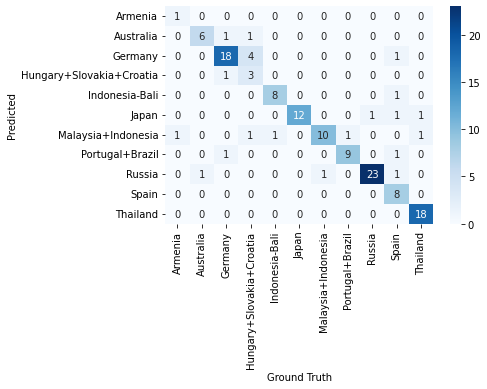

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cnf = confusion_matrix(predicted_df["predicted"], predicted_df["gt"])
cnf_df = pd.DataFrame(cnf,columns = class_names,index=class_names)
ax = sns.heatmap(cnf_df,annot=True, cmap='Blues')
ax.set(xlabel='Ground Truth', ylabel='Predicted')
plt.savefig("eff_b3_cf.png")

In [77]:
classwise_accuracy_b3 = predicted_df.groupby("gt").mean()["match"]

In [90]:
classwise_accuracy_b3

gt
Armenia                     0.500000
Australia                   0.857143
Germany                     0.857143
Hungary+Slovakia+Croatia    0.333333
Indonesia-Bali              0.888889
Japan                       1.000000
Malaysia+Indonesia          0.909091
Portugal+Brazil             0.900000
Russia                      0.958333
Spain                       0.615385
Thailand                    0.900000
Name: match, dtype: float64

In [79]:
predicted_df.to_csv("b3.csv",index=False)

# Efficient B0

In [98]:
import numpy as np
def predictModel224(dataloaders,model,x):
    predicted = []
    was_training = False
    model.eval()
    device = "cpu"
    with torch.no_grad():
        for i, image in enumerate(dataloaders['val']):
            inputs = data_transforms_224(Image.open(image[0])).unsqueeze(0)
            inputs = inputs.to(device)
            outputs = model(inputs)
            output_1 = nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            prob = output_1.tolist()[0]            
            classes = [class_names[pred] for pred in preds]

            for j in range(inputs.size()[0]):
                if(x==class_names[preds[j]]):
                    match=1
                else:
                    match=0
                predicted.append({"image":image[0],"gt":x,"predicted":class_names[preds[j]],"conf":max(output_1[j]),"match":match})
    return predicted

In [108]:
def getModelPred224(model):
    predicted = []
    for x in os.listdir("data/test/"):
        dataloaders = {"val": torch.utils.data.DataLoader(["data/test/"+x+"/"+z for z in  os.listdir("data/test/"+x)], batch_size=1,
                                                 shuffle=True, num_workers=4)}
        device="cpu"
        predicted += predictModel224(dataloaders,model,x)
    return predicted

In [109]:
model = models.efficientnet_b0()
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs,11)
model_path = torch.load("models/temple-classifier-effb0.pt",map_location=torch.device("cpu"))
model.load_state_dict(model_path)

<All keys matched successfully>

In [113]:
predicted_b0 = getModelPred224(model)

In [114]:
predicted_df_b0 = pd.DataFrame(predicted_b0)
print(np.average(predicted_df_b0["match"].values))

0.8188405797101449


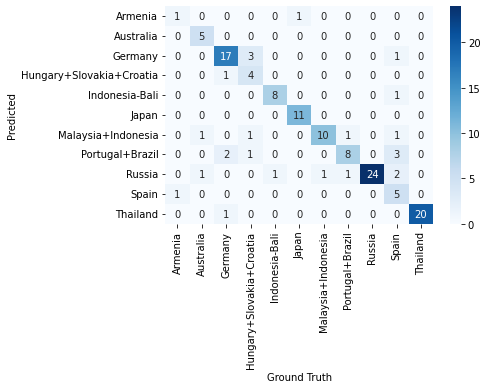

In [115]:
cnf = confusion_matrix(predicted_df_b0["predicted"], predicted_df_b0["gt"])
cnf_df = pd.DataFrame(cnf,columns = class_names,index=class_names)
ax = sns.heatmap(cnf_df,annot=True, cmap='Blues')
ax.set(xlabel='Ground Truth', ylabel='Predicted')
plt.savefig("eff_b0_cf.png")

In [116]:
classwise_accuracy_b0 = predicted_df_b0.groupby("gt").mean()["match"]

In [117]:
classwise_accuracy_b0

gt
Armenia                     0.500000
Australia                   0.714286
Germany                     0.809524
Hungary+Slovakia+Croatia    0.444444
Indonesia-Bali              0.888889
Japan                       0.916667
Malaysia+Indonesia          0.909091
Portugal+Brazil             0.800000
Russia                      1.000000
Spain                       0.384615
Thailand                    1.000000
Name: match, dtype: float64

# VGG16

In [118]:
model = models.vgg16()
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 11)
model_path = torch.load("models/temple-classifier-vgg.pt",map_location=torch.device("cpu"))
model.load_state_dict(model_path)

<All keys matched successfully>

In [119]:
predicted_vgg = getModelPred224(model)

In [120]:
predicted_df_vgg = pd.DataFrame(predicted_vgg)
print(np.average(predicted_df_vgg["match"].values))

0.8115942028985508


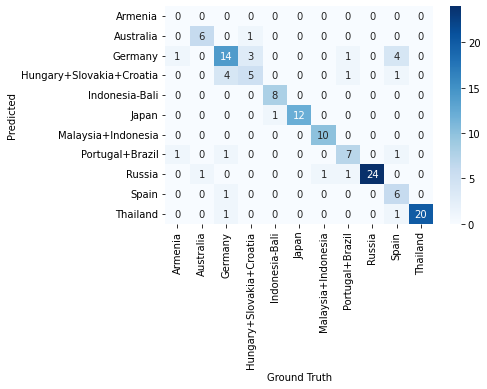

In [121]:
cnf = confusion_matrix(predicted_df_vgg["predicted"], predicted_df_vgg["gt"])
cnf_df = pd.DataFrame(cnf,columns = class_names,index=class_names)
ax = sns.heatmap(cnf_df,annot=True, cmap='Blues')
ax.set(xlabel='Ground Truth', ylabel='Predicted')
plt.savefig("eff_vgg_cf.png")

In [122]:
classwise_accuracy_vgg = predicted_df_vgg.groupby("gt").mean()["match"]

In [123]:
classwise_accuracy_vgg

gt
Armenia                     0.000000
Australia                   0.857143
Germany                     0.666667
Hungary+Slovakia+Croatia    0.555556
Indonesia-Bali              0.888889
Japan                       1.000000
Malaysia+Indonesia          0.909091
Portugal+Brazil             0.700000
Russia                      1.000000
Spain                       0.461538
Thailand                    1.000000
Name: match, dtype: float64

# 1. Classwise Accuracy

In [135]:
final_accuracy_df = pd.DataFrame({"EffB3":classwise_accuracy_b3,"EffB0":classwise_accuracy_b0,"VGG16":classwise_accuracy_vgg})
final_accuracy_df_melt = pd.melt(final_accuracy_df.reset_index(),id_vars='gt', var_name='Model', value_name='Accuracy')

[Text(0.5, 0, 'Class'), Text(0, 0.5, 'Accuracy')]

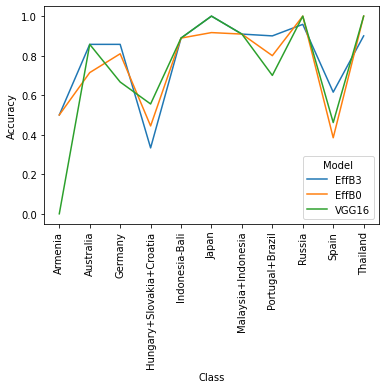

In [141]:
ax = sns.lineplot(x="gt", y="Accuracy", hue='Model', data=final_accuracy_df_melt)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Class', ylabel='Accuracy')

# 2. Distributionwise Accuracy on augmented training 

In [145]:
train_path = "data/data/train/"

In [148]:
training_image_count = 0
for x in os.listdir(train_path):
    training_image_count += len(os.listdir(train_path+x))
print(training_image_count)

3144


In [150]:
distribution = []
gt = []
for x in os.listdir(train_path):
    distribution.append(len(os.listdir(train_path+x))/training_image_count)
    gt.append(x)
distribution_series = pd.Series(distribution,index=gt,name="gt")

In [156]:
distribution_df = pd.DataFrame({"EffB3_Acc":classwise_accuracy_b3,"distribution":distribution_series}).reset_index()

In [159]:
# Done just so that the values match and graph is easier to interpret
distribution_df["distribution_temp"] = [x*10 for x in distribution_df["distribution"]]

[Text(0.5, 0, 'Class'), Text(0, 0.5, 'Accuracy')]

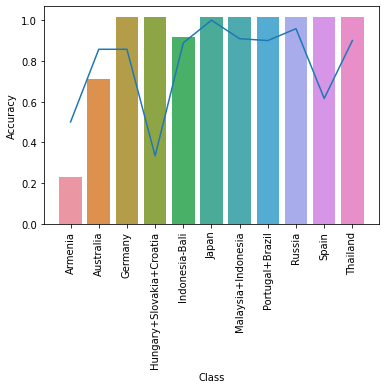

In [160]:
ax = sns.barplot(x="index", y="distribution_temp", data=distribution_df)
ax = sns.lineplot(x="index", y="EffB3_Acc", data=distribution_df)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Class', ylabel='Accuracy')

SINCE WE ARE CHANGING THE DISTRUBUTION AFTER AUGMENTING WE DONT GET ANY TREND 

# 3. Distributionwise Accuracy on unaugmented training 

**Augmented Images start with phrase aug_ the images other than those are unagumented images**

In [164]:
training_unaug_image_count = 0
for x in os.listdir(train_path):
    for image in os.listdir(train_path+x):
        if("aug_" not in image):
            training_unaug_image_count += 1
print(training_unaug_image_count)

464


In [165]:
distribution = []
gt = []
for x in os.listdir(train_path):
    class_images = 0
    for image in os.listdir(train_path+x):
        if("aug_" not in image):
            class_images += 1
    distribution.append(class_images/training_unaug_image_count)
    gt.append(x)
distribution_series = pd.Series(distribution,index=gt,name="gt")

In [168]:
distribution_df = pd.DataFrame({"EffB3_Acc":classwise_accuracy_b3,"distribution":distribution_series}).reset_index()
# Done just so that the values match and graph is easier to interpret
distribution_df["distribution_temp"] = [x*5 for x in distribution_df["distribution"]]

[Text(0.5, 0, 'Class'), Text(0, 0.5, 'Accuracy')]

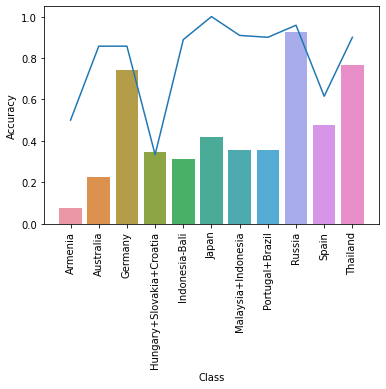

In [169]:
ax = sns.barplot(x="index", y="distribution_temp", data=distribution_df)
ax = sns.lineplot(x="index", y="EffB3_Acc", data=distribution_df)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Class', ylabel='Accuracy')

# The classes with the lowest accuracy are also have low distribution and also all three(Spain,Hungary,Armenia) have temples which are churches that are common occuring;

# 4. Subclass

# **In each of the class there are a bunch of name with same prefix; that prefix is the location of temple and that will be our subclass; the number of subclass can correspond to the variance of the class**

In [189]:
subclass = []
gt = []
for x in os.listdir(train_path):
    subclass_list = []
    for image in os.listdir(train_path+x):
        if("aug_" not in image):
            subclass_list.append(image.split("_")[0])
    print(x,set(subclass_list))
    subclass.append(len(set(subclass_list)))
    gt.append(x)
subclass_series = pd.Series(subclass,index=gt,name="gt")

Australia {'Perth', 'Brisbane', 'Melbourne', 'Sydney', 'Blue', 'Canberra', 'Goulburn', 'Hobart', 'Adelaide'}
Indonesia-Bali {'Bali'}
Germany {'Berlin', 'Hannover', 'Lindau', 'Freiburg', 'Munich', 'Bremen', 'Lubeck', 'Stuttgart', 'Aachen', 'Hamelin', 'Luneburg', 'Hildesheim', 'Speyer', 'Plon', 'Karlsruhe', 'Augsburg', 'Uelzen', 'Celle', 'Wiesbaden', 'Regensburg', 'Cologne', 'Mainz', 'Mannheim', 'Kiel', 'Starnberg', 'Frankfurt', 'Baden', 'Hamburg', 'Offenburg', 'Koblenz', 'Simbach', 'Goslar'}
Armenia {'Garni', 'Armenia', 'Echmiadzin'}
Portugal+Brazil {'Coimbra', 'Guimaraes', 'Ouro', 'Elvas', 'Florianopolis', 'Braga', 'Lisboa', 'Evora', 'Congonhas', 'Porto', 'Sao', 'Rio', 'Belo', 'Faro', 'Aveiro'}
Japan {'Fukuoka', 'Hiroshima', 'Tokyo', 'Inuyama', 'Kagoshima', 'Mihara', 'Kamakura', 'Kyoto', 'Nara'}
Thailand {'Phanom', 'Udon', 'Phimai', 'Narathiwat', 'Khon', 'Sukhothai', 'Kamphaeng', 'Phetchaburi', 'Trat', 'Nakhon', 'Bangkok', 'Pattaya', 'Chiang', 'Nong', 'Ayutthaya'}
Spain {'Badajoz', 'Za

In [190]:
subclass_normalized = [(data - np.min(subclass)) / (np.max(subclass) - np.min(subclass)) for data in subclass]

In [191]:
subclass_normalized_series = pd.Series(subclass_normalized,index=gt,name="gt")

In [192]:
subclass_df = pd.DataFrame({"EffB3_Acc":classwise_accuracy_b3,"sub":subclass_normalized_series}).reset_index()

In [193]:
subclass_normalized_series

Australia                   0.258065
Indonesia-Bali              0.000000
Germany                     1.000000
Armenia                     0.064516
Portugal+Brazil             0.451613
Japan                       0.258065
Thailand                    0.451613
Spain                       0.516129
Malaysia+Indonesia          0.419355
Hungary+Slovakia+Croatia    0.483871
Russia                      0.903226
Name: gt, dtype: float64

[Text(0.5, 0, 'Class'), Text(0, 0.5, 'Accuracy')]

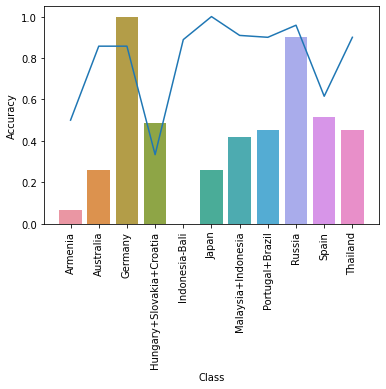

In [194]:
ax = sns.barplot(x="index", y="sub", data=subclass_df)
ax = sns.lineplot(x="index", y="EffB3_Acc", data=subclass_df)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Class', ylabel='Accuracy')

# Low classes can correspond to low number of images

# Conclusion

From 3. and 4. we can conclude that the reason for poor performance on Spain and Hungary is due to the reason that a.) they have less distribution of images in training set b#. the class has larger amount of subclasses causing a higher variance hence requiring more data  